# load all the libraries and modules

In [31]:
# DATA SET
# Link ---> https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
#from ensemble_learning import StackedHybrid

plt.style.use("fivethirtyeight")

In [32]:
df = pd.read_csv("PJME_hourly.csv", 
                   index_col=[0], 
                   parse_dates=[0])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# Outlier Analysis

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

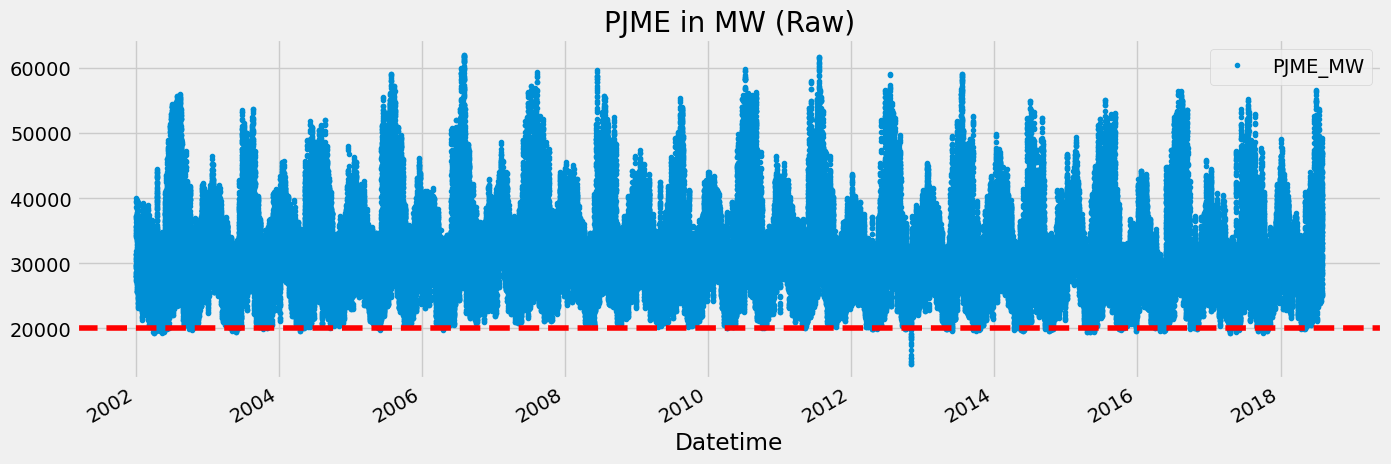

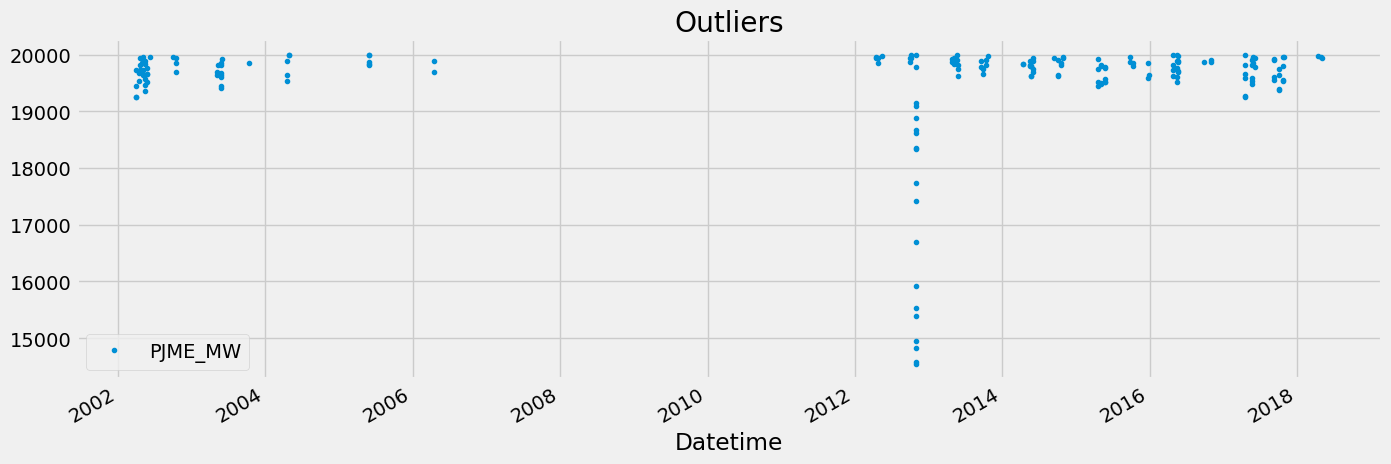

In [33]:
df.plot(figsize=(15,5),
        style=".",
        title = "PJME in MW (Raw)")
plt.axhline(20000, color="red", ls="--")

df.query("PJME_MW < 20_000").plot(figsize=(15,5), 
                                  style=".", 
                                  title="Outliers" )

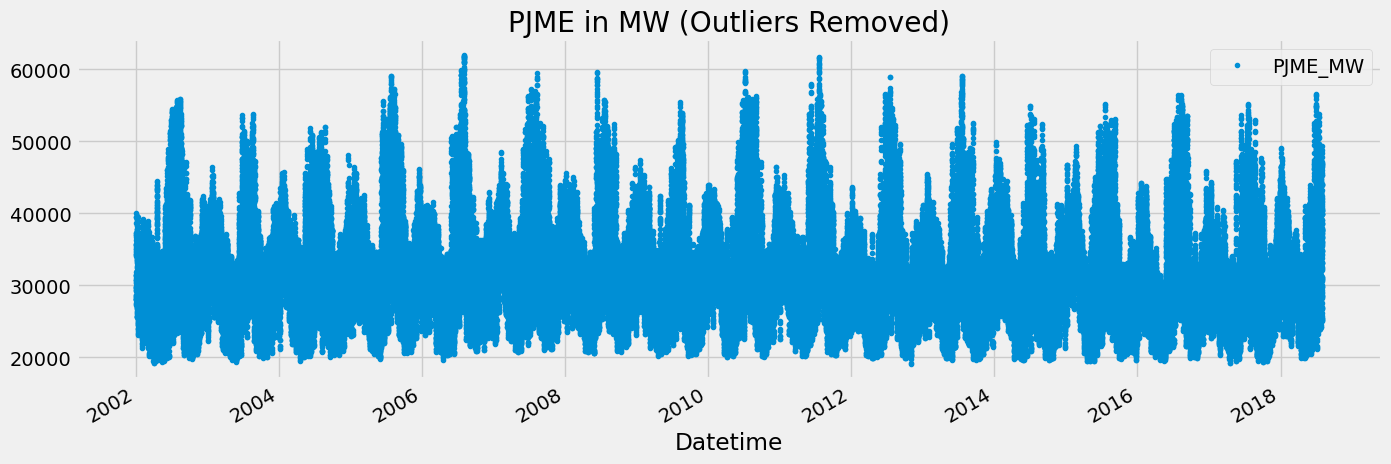

In [34]:
# eleminate obvious Outliers
df = df.query("PJME_MW > 19_000").copy()
naked_df = df.copy()

df.plot(figsize=(15,5),
        style=".",
        title = "PJME in MW (Outliers Removed)")
plt.show()

# Feature Engineering

In [35]:
def generate_lagFeatures(df):
    """
    Generates Lag Features for Several Time Intervals
    """    
    df = df.sort_index()
    target_map = df["PJME_MW"].to_dict()
    
    df["lag0"] = (df.index - pd.Timedelta("7 days")).map(target_map)
    df["lag1"] = (df.index - pd.Timedelta("30 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag4"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [36]:
us_holidays = holidays.UnitedStates()
df = generate_lagFeatures(df)
df.tail()

,PJME_MW,lag0,lag1,lag2,lag3,lag4
Datetime,,,,,,
2018-08-02 20:00:00,44057.0,46337.0,49244.0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,44542.0,47292.0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,42638.0,45506.0,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,39276.0,42437.0,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,35742.0,39340.0,33539.0,32094.0,31695.0


In [37]:
def cluster(df):
    """
    k-Means Applied for Clustering, try k-Medeoids too!!
    """
    cluster_mapping = {0: "normal", 1: "low", 
                       2: "high", 3:"extreme"}
    col = np.array(df["PJME_MW"]).reshape(-1, 1)
   
    kmeans = KMeans(n_clusters=4, random_state=0, init='k-means++', n_init="auto").fit(col)
    
    df['cluster'] = kmeans.labels_
    df['cluster'] = df['cluster'].map(cluster_mapping)
    label_counts = df['cluster'].value_counts()
    print("Cluster Label Counts:")
    print(label_counts,"\n")
    print("cluster_centers")
    print(kmeans.cluster_centers_)
    return df

In [38]:
df = cluster(df)
df = pd.get_dummies(df, columns = ["cluster"])
df.head()

Cluster Label Counts:
extreme    57967
low        37803
normal     37198
high       12383
Name: cluster, dtype: int64 

cluster_centers
[[36844.71744722]
 [24700.332873  ]
 [45991.22937545]
 [30815.47602763]]


,PJME_MW,lag0,lag1,lag2,lag3,lag4,cluster_extreme,cluster_high,cluster_low,cluster_normal
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0


In [40]:
def generate_tsFeatures(df,label=None):
    """
    Generates Time Series Features
    """
    # Dictionary mapping months to seasons
    seasons_mapping = {
        1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 
        6: "summer", 7: "summer", 8: "summer", 9: "fall", 10: "fall", 11: "fall", 12: "winter"}
    df = df.copy()
    df["date"] = df.index
    df["hour"] = df["date"].dt.hour
    df["dayoftheweek"] = df["date"].dt.dayofweek
    df["week"] = df["date"].dt.isocalendar().week # quite strong pattern on weekly
    df["quarter"] = df["date"].dt.quarter
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week
    df['season'] = df['month'].map(seasons_mapping)
    df['is_holiday'] = df.index.map(is_holiday)
    df =df.drop(["date"],axis=1)
    df = pd.get_dummies(df, columns = ["season","is_holiday"])
    
    mask = ~df.columns.isin(['PJME_MW'])
    X = df.loc[:, mask]
    
    if label:
        y = df[label]
        return X, y
    return X

In [41]:
def is_holiday(date):
    """
    Checks if Date is a US Holiday (since Data set is scrapped from US)
    """
    return date in us_holidays

In [42]:
X, y = generate_tsFeatures(df, label="PJME_MW")
merged_df = X.merge(y, left_index=True, right_index=True)
merged_df.tail(15)

,lag0,lag1,lag2,lag3,lag4,cluster_extreme,cluster_high,cluster_low,cluster_normal,hour,...,dayofyear,dayofmonth,weekofyear,season_fall,season_spring,season_summer,season_winter,is_holiday_False,is_holiday_True,PJME_MW
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-02 10:00:00,36666.0,45766.0,36162.0,35299.0,34577.0,0,0,0,1,10,...,214,2,31,0,0,1,0,1,0,39902.0
2018-08-02 11:00:00,38660.0,48876.0,38510.0,37130.0,36367.0,0,1,0,0,11,...,214,2,31,0,0,1,0,1,0,42189.0
2018-08-02 12:00:00,40547.0,51603.0,40807.0,38835.0,37918.0,0,1,0,0,12,...,214,2,31,0,0,1,0,1,0,43954.0
2018-08-02 13:00:00,42325.0,53623.0,42869.0,40173.0,39249.0,0,1,0,0,13,...,214,2,31,0,0,1,0,1,0,45372.0
2018-08-02 14:00:00,44214.0,54852.0,44890.0,41493.0,40500.0,0,1,0,0,14,...,214,2,31,0,0,1,0,1,0,46534.0
2018-08-02 15:00:00,45954.0,54908.0,46462.0,42631.0,41414.0,0,1,0,0,15,...,214,2,31,0,0,1,0,1,0,47154.0
2018-08-02 16:00:00,47369.0,54908.0,47318.0,43575.0,41956.0,0,1,0,0,16,...,214,2,31,0,0,1,0,1,0,46989.0
2018-08-02 17:00:00,48525.0,54724.0,47490.0,44267.0,41920.0,0,1,0,0,17,...,214,2,31,0,0,1,0,1,0,46816.0
2018-08-02 18:00:00,49029.0,53679.0,46436.0,44460.0,41430.0,0,1,0,0,18,...,214,2,31,0,0,1,0,1,0,46760.0


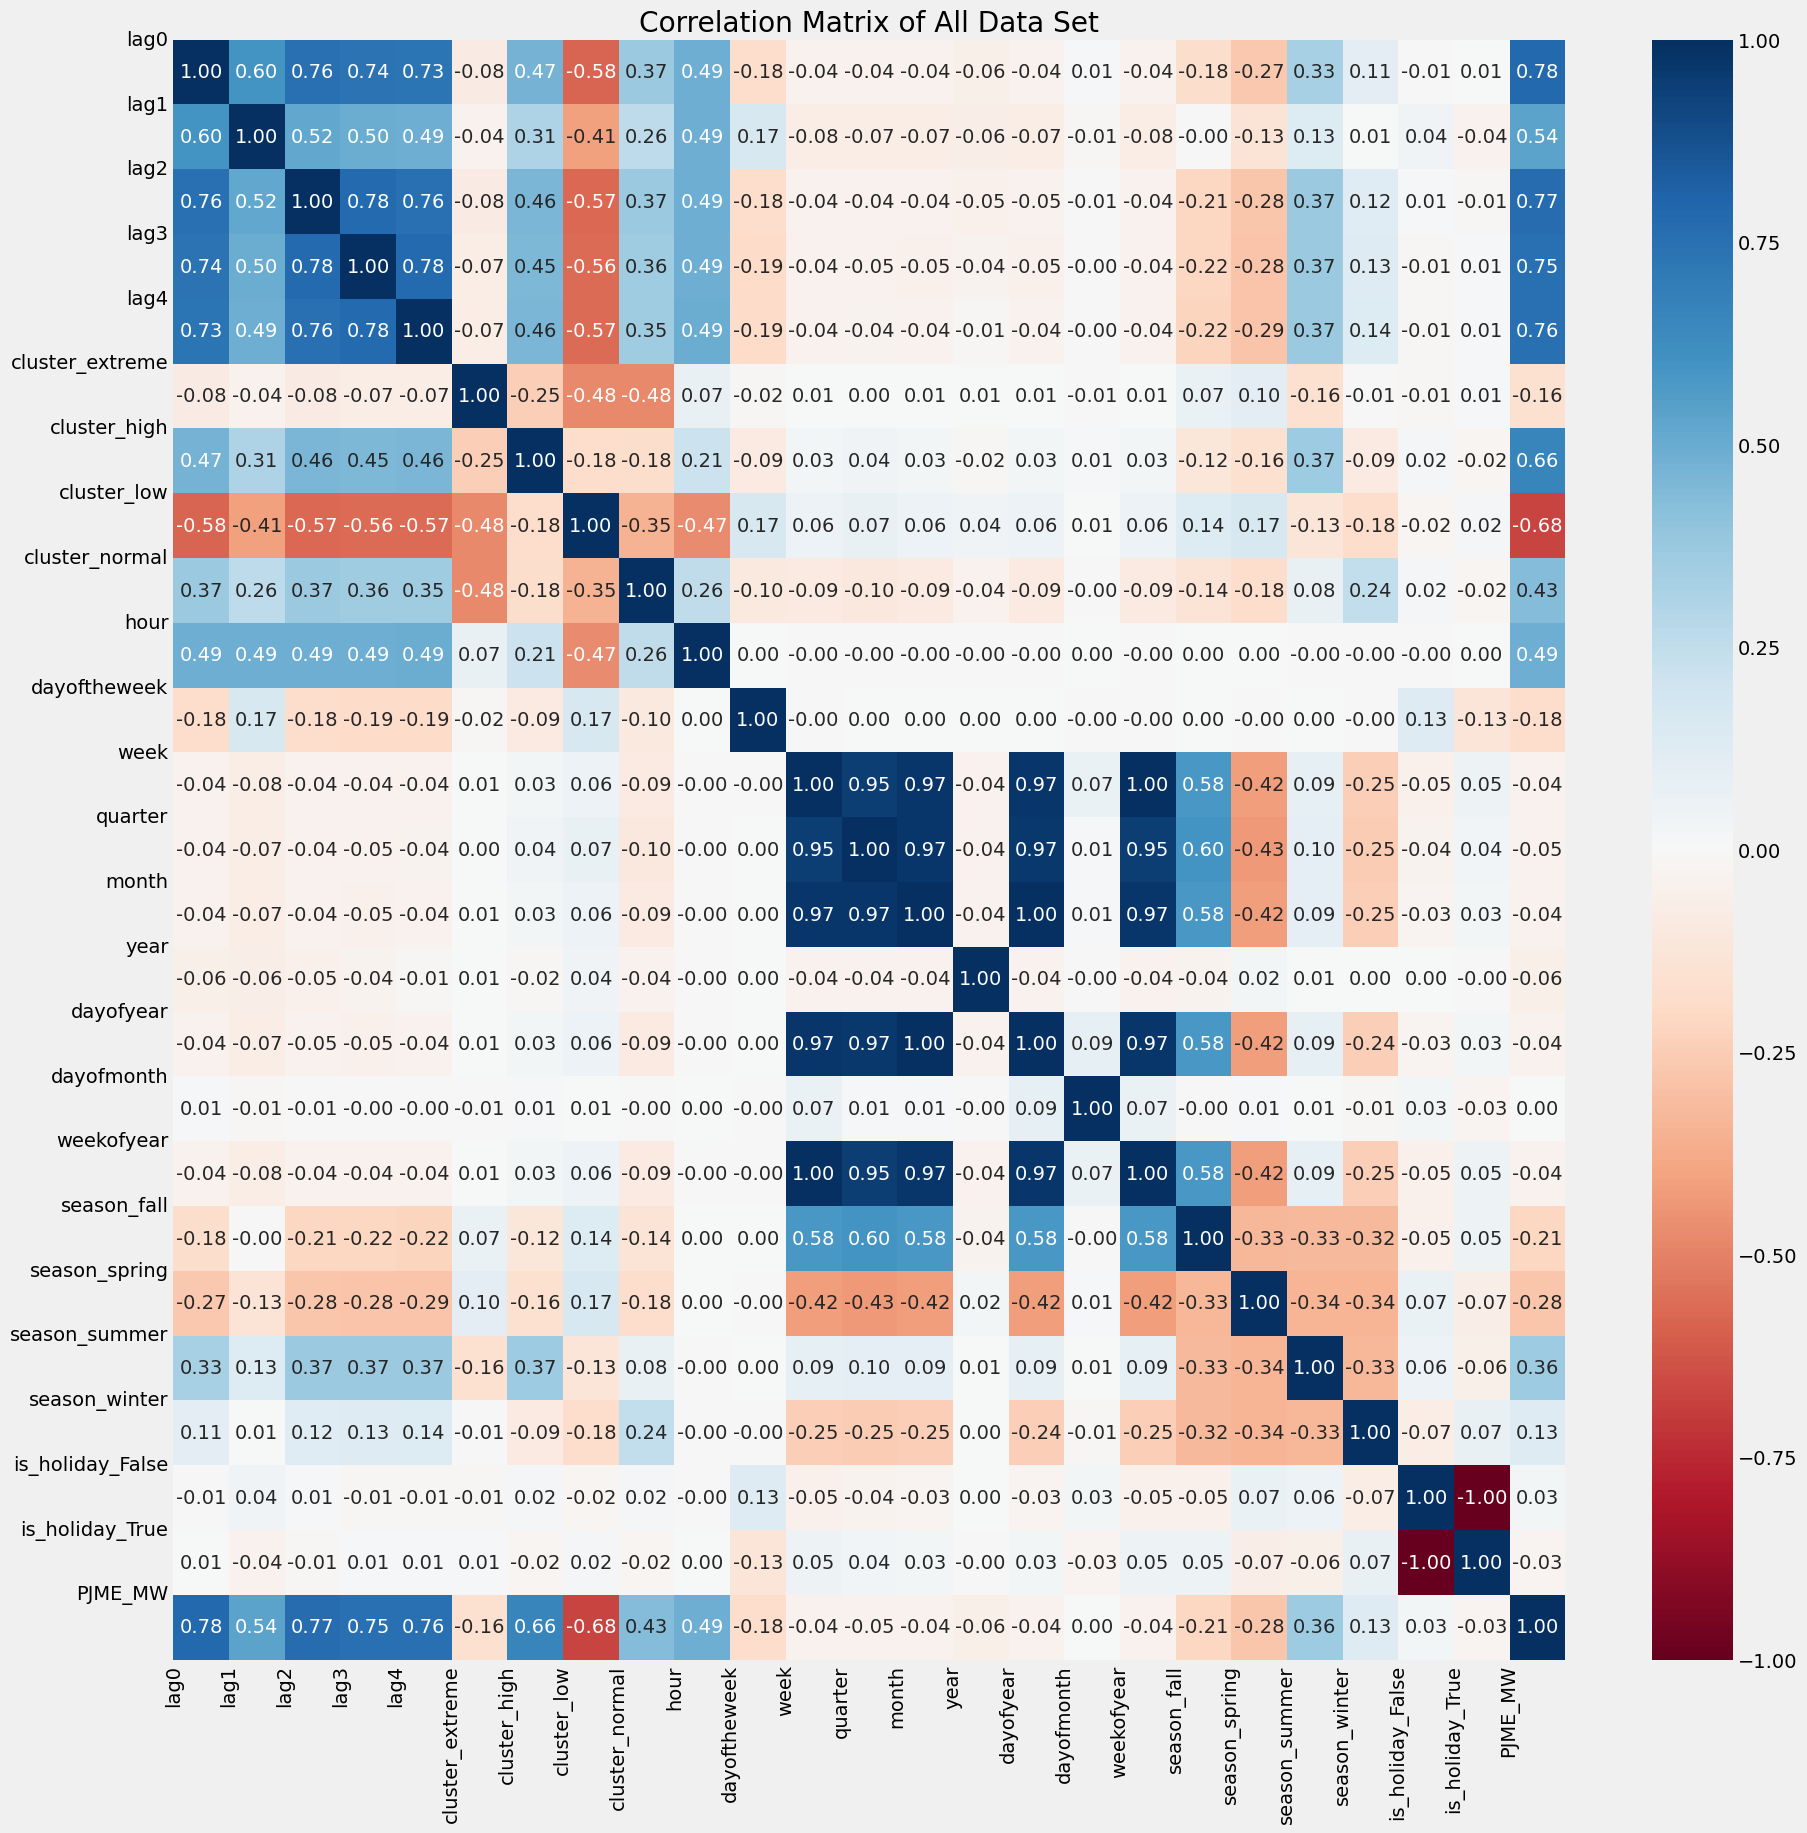

In [43]:
corr = merged_df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix of All Data Set")
plt.show()

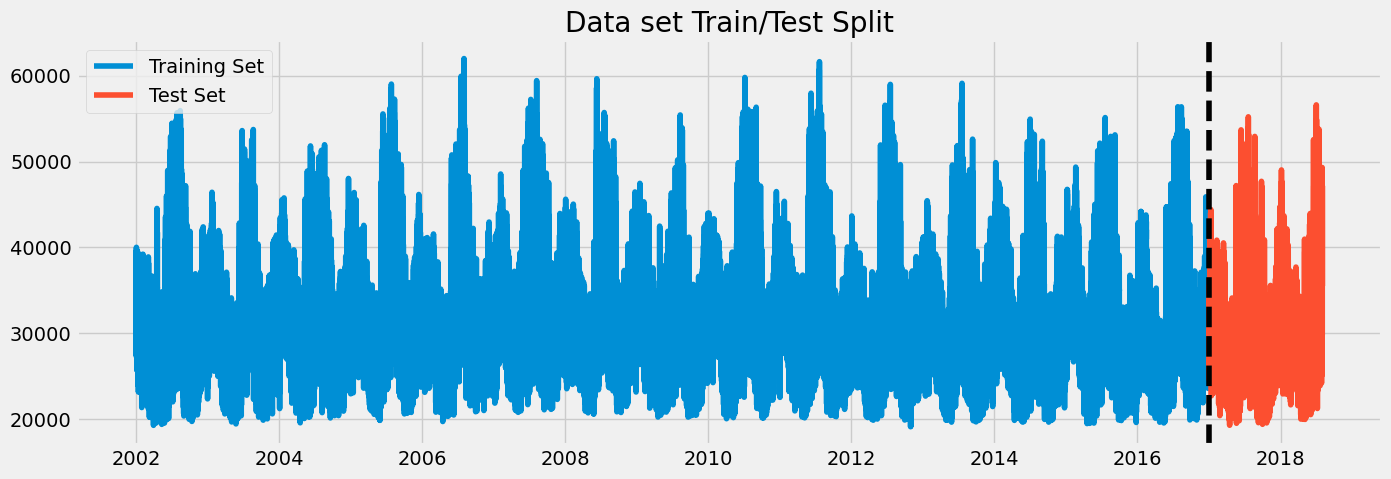

In [44]:
train = df.loc[df.index < "2017-01-01"]
test = df.loc[df.index >= "2017-01-01"]

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(train.index, train["PJME_MW"])
plt.plot(test.index, test["PJME_MW"])
ax.axvline(train.index.max(), color = "black", ls="--")
ax.legend(["Training Set", "Test Set"])
plt.title("Data set Train/Test Split")
plt.show()

In [45]:
X_train, y_train = generate_tsFeatures(train, label="PJME_MW")
X_test, y_test = generate_tsFeatures(test, label="PJME_MW")
X_train.tail()

,lag0,lag1,lag2,lag3,lag4,cluster_extreme,cluster_high,cluster_low,cluster_normal,hour,...,year,dayofyear,dayofmonth,weekofyear,season_fall,season_spring,season_summer,season_winter,is_holiday_False,is_holiday_True
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-12-31 19:00:00,31787.0,33862.0,33041.0,35781.0,40478.0,0,0,0,1,19,...,2016,366,31,52,0,0,0,1,1,0
2016-12-31 20:00:00,31040.0,33468.0,32878.0,34893.0,40043.0,1,0,0,0,20,...,2016,366,31,52,0,0,0,1,1,0
2016-12-31 21:00:00,30532.0,32799.0,32586.0,33847.0,39472.0,1,0,0,0,21,...,2016,366,31,52,0,0,0,1,1,0
2016-12-31 22:00:00,29947.0,31419.0,31877.0,32490.0,38499.0,1,0,0,0,22,...,2016,366,31,52,0,0,0,1,1,0
2016-12-31 23:00:00,28963.0,29157.0,30590.0,30764.0,36981.0,1,0,0,0,23,...,2016,366,31,52,0,0,0,1,1,0


In [46]:
params = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'seed': 0
    }

In [47]:
def model_specification(params):
    XGBR = XGBRegressor(
        n_estimators = int(params['n_estimators']),
        max_depth = int(params['max_depth']),
        gamma = params['gamma'],
        reg_alpha = int(params['reg_alpha']),
        min_child_weight = int(params['min_child_weight']),
        colsample_bytree = params['colsample_bytree'],
        reg_lambda = params['reg_lambda']
    )
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    XGBR.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10, verbose=False)

    pred = XGBR.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print("SCORE:", rmse)
    return {'loss': rmse, 'status': STATUS_OK}

def hyperparameter_tuning():
    trials = Trials()
    
    best_hyperparams = fmin(fn=model_specification,
                            space=params,
                            algo=tpe.suggest,
                            max_evals=100,
                            trials=trials)
    print("The best hyperparameters are : ", "\n")
    print(best_hyperparams)
    
# Call hyperparameter_tuning function
# hyperparameter_tuning() 


#### SCORE:                                                                            
#### 1957.0208132973419                                                                
#### 100%|██████████| 100/100 [00:38<00:00,  2.62trial/s, best loss: 1813.4803574016025]
#### The best hyperparameters are :  
 
#### {'colsample_bytree': 0.9250478304807515, 'gamma': 8.911832602537249, 'max_depth': 6.0, 
#### 'min_child_weight': 0.0, 'n_estimators': 200.0, 'reg_alpha': 171.0, 'reg_lambda': 0.6754320528375728}

In [18]:
# Cross Validation
def timeseries_cv(df):
    """
    Time Series 5-fold Cross Validation
    Train Set Size = 15years (15*24*365 hours)
    Test Set Size = 1years (1*24*365 hours)
    Gap = 1day (24 hours)
    booster = gbtree
    n_estimators = 800 (more of it may result in overfit!)
    """
    # one-year for test 
    ts_split = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
    fig, axis = plt.subplots(5,1, figsize=(15,15), sharex = True) 
    fold=0
    predicts = list()
    scores = list()

    for train_idx, val_idx in ts_split.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        
        train["PJME_MW"].plot(ax=axis[fold],
                              label="Training Set",)
        test["PJME_MW"].plot(ax=axis[fold],
                              label="Test Set",
                              title=f"Data Train/Test Split fold {fold}")
        axis[fold].axvline(train.index.max(), color = "black", ls="--")
        fold+=1
        
        X_train, y_train = generate_tsFeatures(train, label="PJME_MW")
        X_test, y_test = generate_tsFeatures(test, label="PJME_MW")
        
        XGBR = XGBRegressor(n_estimators = 800,
                                base_score = 0.5,
                                booster = "gbtree",
                                max_depth = 3,
                                objective="reg:linear",
                                early_stopping_rounds = 50,
                                learning_rate = 0.01)
        XGBR.fit(X_train, y_train,
                eval_set = [(X_train,y_train), (X_test, y_test)],
                verbose = 100)
        
        y_pred = XGBR.predict(X_test)
        predicts.append(y_pred)
        mse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(mse)
        
    plt.show()
    print(f"Score across folds {np.mean(scores):0.4f}")
    print(f"Fold Scores: {scores}")

# call cross validation function
# timeseries_cv(df)

# Train

In [48]:
xgb = XGBRegressor(n_estimators = 800,
                   booster = "gbtree",
                   early_stopping_rounds = 50,
                   learning_rate = 0.01)
xgb.fit(X_train, y_train,
        eval_set = [(X_train,y_train), (X_test, y_test)],
        eval_metric="rmse",
        verbose = 10)

[0]	validation_0-rmse:6428.27294	validation_1-rmse:6167.97057
[10]	validation_0-rmse:5866.38142	validation_1-rmse:5623.68941
[20]	validation_0-rmse:5362.77775	validation_1-rmse:5135.77591


/Users/candilsiz/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:4912.16271	validation_1-rmse:4700.52430
[40]	validation_0-rmse:4509.71700	validation_1-rmse:4312.88090
[50]	validation_0-rmse:4151.01035	validation_1-rmse:3969.04356
[60]	validation_0-rmse:3832.12579	validation_1-rmse:3664.03253
[70]	validation_0-rmse:3549.41111	validation_1-rmse:3394.79009
[80]	validation_0-rmse:3299.70448	validation_1-rmse:3156.34694
[90]	validation_0-rmse:3079.73057	validation_1-rmse:2947.89787
[100]	validation_0-rmse:2886.64141	validation_1-rmse:2768.48766
[110]	validation_0-rmse:2718.02616	validation_1-rmse:2611.17717
[120]	validation_0-rmse:2571.12068	validation_1-rmse:2474.94842
[130]	validation_0-rmse:2443.78180	validation_1-rmse:2358.38860
[140]	validation_0-rmse:2333.76156	validation_1-rmse:2258.95770
[150]	validation_0-rmse:2239.07954	validation_1-rmse:2175.79668
[160]	validation_0-rmse:2157.99813	validation_1-rmse:2105.01112
[170]	validation_0-rmse:2088.68413	validation_1-rmse:2046.56226
[180]	validation_0-rmse:2029.74580	validation_1

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

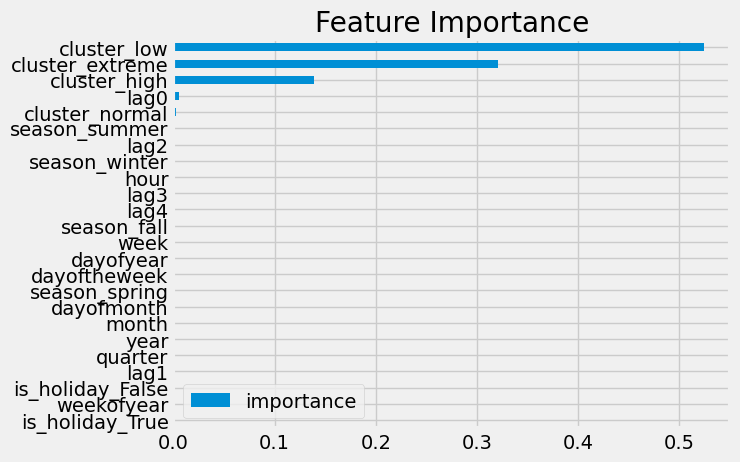

In [49]:
feature_importance = pd.DataFrame(data = xgb.feature_importances_,
                                  index = xgb.feature_names_in_,
                                  columns = ["importance"])

feature_importance.sort_values("importance").plot(kind="barh",title="Feature Importance")

# Prediction

/var/folders/fm/4vfl29px4_15c1dns3s89nk80000gn/T/ipykernel_4225/1265135696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = xgb.predict(X_test)


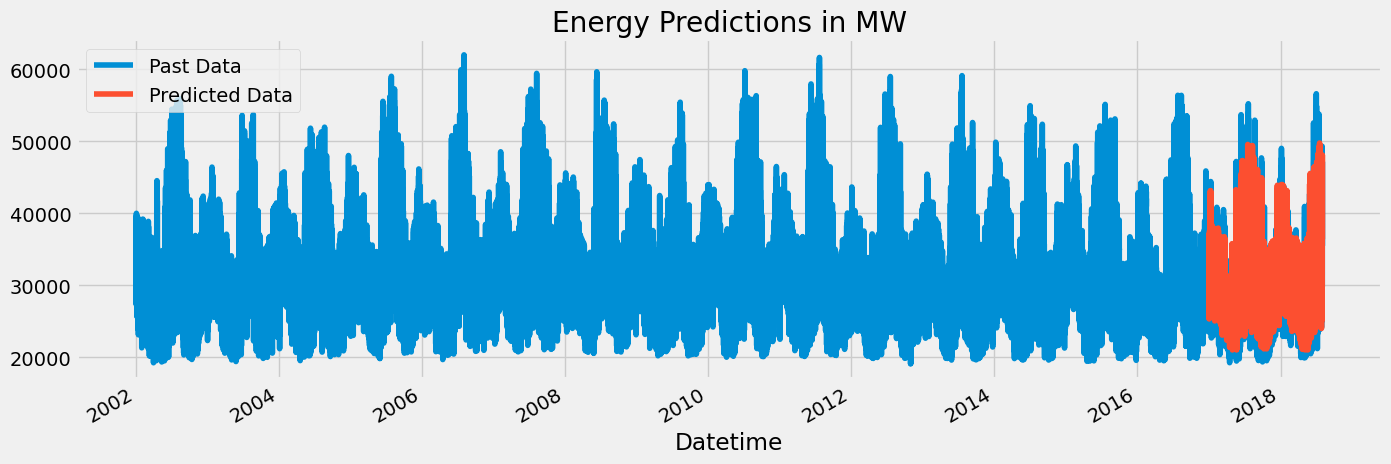

In [50]:
test["prediction"] = xgb.predict(X_test)
test.index = pd.to_datetime(test.index)

df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

ax = df[["PJME_MW"]].plot(figsize = (15,5))
df["prediction"].plot(ax=ax)
plt.legend(["Past Data", "Predicted Data"])
ax.set_title("Energy Predictions in MW")
plt.show() 

# Error Metrics

In [51]:
# RMSE 
rsme_score = np.sqrt(mean_squared_error(test["PJME_MW"], test["prediction"]))
print(f"RMSE Score on Test set: {rsme_score:0.2f}")

RMSE Score on Test set: 1808.57


In [52]:
def mape(y, y_hat):
    """
    Mean Absolute Percentage Error (MAPE)
    """
    y, y_hat = np.array(y), np.array(y_hat)
    return np.mean(np.abs((y - y_hat) / y)) *100

In [53]:
# MAPE 
mape_score = mape(test["PJME_MW"], test["prediction"])
print(f"Mean Absolute Percantage Error: %{mape_score:0.2f}")

Mean Absolute Percantage Error: %4.61


In [55]:
test["error"] = np.abs(test["PJME_MW"] - test["prediction"])
test["date"] = test.index.date

worst_predicted = test.groupby("date")["error"].mean().sort_values(ascending = False).head(10)
best_predicted = test.groupby("date")["error"].mean().sort_values(ascending = True).head(10)

print(f"\nTop 10 Worst Prediction by date: {worst_predicted}\n")
print(f"Top 10 Best Prediction by date: {best_predicted}")



Top 10 Worst Prediction by date: date
2018-07-02    5083.352214
2018-07-03    3838.129557
2017-07-20    3634.644531
2017-06-13    3355.861003
2017-02-24    3237.390869
2018-06-18    3117.456787
2017-10-10    3105.510498
2017-03-15    3056.676107
2018-01-01    2898.600586
2018-07-01    2863.066325
Name: error, dtype: float64

Top 10 Best Prediction by date: date
2017-04-25    343.178385
2017-11-02    363.579264
2018-05-13    415.758219
2017-04-26    464.317627
2018-05-22    497.836995
2018-06-03    498.989583
2018-05-17    500.281087
2017-01-01    530.512370
2017-05-22    544.699300
2017-11-16    565.791829
Name: error, dtype: float64


# Ensemble Learning: Stacking Model

In [56]:
class StackedHybrid:
    """
    inputs: model_1, model_1, X_1, X_2
    model_1 := weak learner
    model_2 := strong learner
    X_1 := Dataframe only includes time series features
    X_2 := Dataframe  includes all time series features
    """
    def __init__(self, model_1, model_2):
        self.model_1 = model_1  # Linear Regression
        self.model_2 = model_2  # XGBoost
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_pred_1 = self.model_1.predict(X_1)

        X_2_augmented = X_2.copy()
        X_2_augmented['LR_pred'] = y_pred_1  # append as new feature / stacking here
        
        X_2_train, X_2_val, y_train, y_val = train_test_split(X_2_augmented, y, test_size=0.15, shuffle=False)
        self.model_2.fit(X_2_train, y_train,
                         eval_set=[(X_2_val, y_val)],
                         eval_metric="rmse",
                         verbose=True)
        
    def predict(self, X_1, X_2):
        y_pred_1 = self.model_1.predict(X_1)
        
        X_2_augmented = X_2.copy()
        X_2_augmented['LR_pred'] = y_pred_1
        
        X_2_train, X_2_test, y_train, y_test = train_test_split(X_2_augmented, y, test_size=0.15, shuffle=False)
        y_pred_2 = self.model_2.predict(X_2_test)
        
        return y_pred_2, y_test

In [57]:
x1 = generate_tsFeatures(naked_df) # x1 includes only time series features
x2 = X                             # x2 includes all features
print("----  Subset Features Dataframe (x1)  ----\n")
print(x1.info() )
print("\n\n----  All Features Dataframe (x2)  ----")
print(x2.info() )                 

----  Subset Features Dataframe (x1)  ----

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145351 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   hour              145351 non-null  int64 
 1   dayoftheweek      145351 non-null  int64 
 2   week              145351 non-null  UInt32
 3   quarter           145351 non-null  int64 
 4   month             145351 non-null  int64 
 5   year              145351 non-null  int64 
 6   dayofyear         145351 non-null  int64 
 7   dayofmonth        145351 non-null  int64 
 8   weekofyear        145351 non-null  UInt32
 9   season_fall       145351 non-null  uint8 
 10  season_spring     145351 non-null  uint8 
 11  season_summer     145351 non-null  uint8 
 12  season_winter     145351 non-null  uint8 
 13  is_holiday_False  145351 non-null  uint8 
 14  is_holiday_True   145351 non-null  uint8 
dtypes: UInt

In [58]:
model_SH = StackedHybrid(
    model_1 = LinearRegression(fit_intercept = False), # -- Weak Learner
    model_2 = XGBRegressor(n_estimators = 800,     # -- Strong Learner
                  early_stopping_rounds = 50,
                  learning_rate = 0.01))
model_SH.fit(x1, x2, y)   

[0]	validation_0-rmse:6482.33344
[1]	validation_0-rmse:6422.67625
[2]	validation_0-rmse:6363.64753
[3]	validation_0-rmse:6305.28804
[4]	validation_0-rmse:6247.49143
[5]	validation_0-rmse:6190.50698
[6]	validation_0-rmse:6134.24103
[7]	validation_0-rmse:6078.44802
[8]	validation_0-rmse:6023.39016
[9]	validation_0-rmse:5968.82245
[10]	validation_0-rmse:5914.99454
[11]	validation_0-rmse:5861.61766
[12]	validation_0-rmse:5808.95759
[13]	validation_0-rmse:5756.87748
[14]	validation_0-rmse:5705.30148
[15]	validation_0-rmse:5654.30875
[16]	validation_0-rmse:5604.11060
[17]	validation_0-rmse:5554.24796
[18]	validation_0-rmse:5504.74380
[19]	validation_0-rmse:5456.14253
[20]	validation_0-rmse:5407.78782
[21]	validation_0-rmse:5360.26382
[22]	validation_0-rmse:5313.03473
[23]	validation_0-rmse:5266.58477


/Users/candilsiz/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:5220.47332
[25]	validation_0-rmse:5174.94572
[26]	validation_0-rmse:5129.81233
[27]	validation_0-rmse:5085.21977
[28]	validation_0-rmse:5041.01460
[29]	validation_0-rmse:4997.77230
[30]	validation_0-rmse:4954.45132
[31]	validation_0-rmse:4912.18810
[32]	validation_0-rmse:4870.10409
[33]	validation_0-rmse:4828.72742
[34]	validation_0-rmse:4787.66094
[35]	validation_0-rmse:4747.01024
[36]	validation_0-rmse:4707.22135
[37]	validation_0-rmse:4667.33664
[38]	validation_0-rmse:4628.22372
[39]	validation_0-rmse:4589.42199
[40]	validation_0-rmse:4550.81800
[41]	validation_0-rmse:4513.16162
[42]	validation_0-rmse:4475.38553
[43]	validation_0-rmse:4438.71165
[44]	validation_0-rmse:4402.73052
[45]	validation_0-rmse:4365.95327
[46]	validation_0-rmse:4330.08222
[47]	validation_0-rmse:4294.93174
[48]	validation_0-rmse:4259.75154
[49]	validation_0-rmse:4225.67845
[50]	validation_0-rmse:4191.35248
[51]	validation_0-rmse:4158.06241
[52]	validation_0-rmse:4124.48090
[53]	validatio

In [59]:
pred, actual = model_SH.predict(x1, x2)
actual = pd.DataFrame(actual)
pred = pd.Series(pred)
actual['predictions'] = pred.values

final_df = actual.copy()

# RMSE 
rsme_score = np.sqrt(mean_squared_error(final_df["PJME_MW"], final_df["predictions"]))
print(f"RMSE Score on Test set: {rsme_score:0.2f}")

# MAPE 
mape_score = mape(final_df["PJME_MW"], final_df["predictions"])
print(f"Mean Absolute Percantage Error: %{mape_score:0.2f}")

final_df["Gap Percentage(%)"] = (((final_df["PJME_MW"] - final_df["predictions"]) / final_df["PJME_MW"])) * 100 
final_df

RMSE Score on Test set: 1857.50
Mean Absolute Percantage Error: %4.63


,PJME_MW,predictions,Gap Percentage(%)
Datetime,,,
2016-02-06 13:00:00,30545.0,31375.796875,-2.719911
2016-02-06 14:00:00,29757.0,30952.822266,-4.018625
2016-02-06 15:00:00,29254.0,30756.246094,-5.135182
2016-02-06 16:00:00,29111.0,30763.792969,-5.677555
2016-02-06 17:00:00,29858.0,30872.130859,-3.396513
...,...,...,...
2018-08-02 20:00:00,44057.0,46228.050781,-4.927823
2018-08-02 21:00:00,43256.0,45489.183594,-5.162714
2018-08-02 22:00:00,41552.0,44678.375000,-7.524006


Text(0.5, 1.0, 'Energy Predictions in MW')

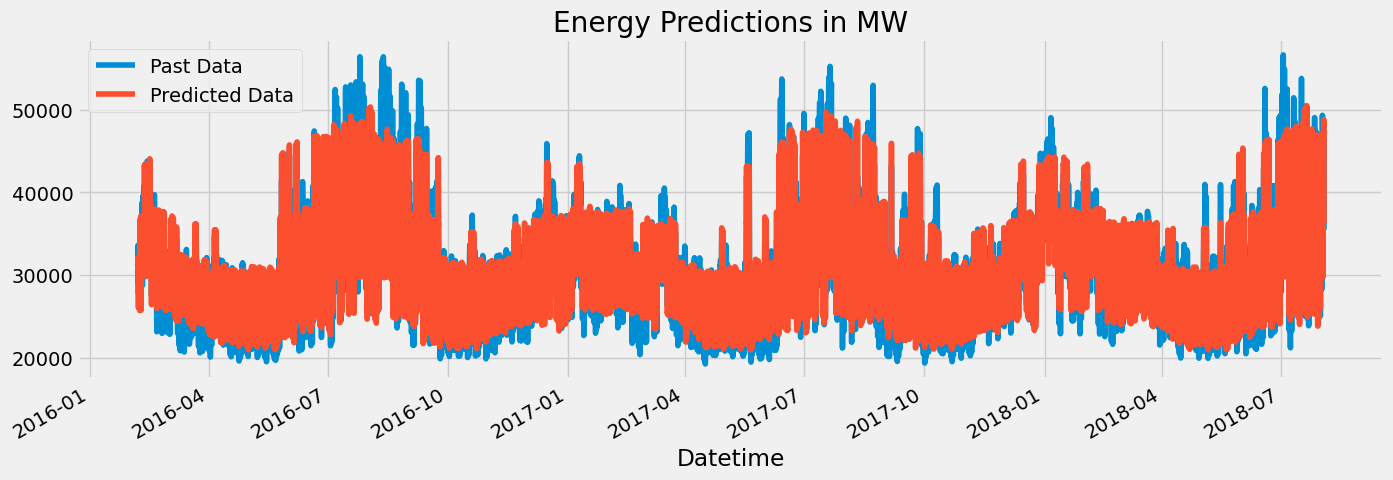

In [60]:
ax = actual[["PJME_MW"]].plot(figsize = (15,5))
actual["predictions"].plot(ax=ax)
plt.legend(["Past Data", "Predicted Data"])
ax.set_title("Energy Predictions in MW")

# ENSEMBLE LEARNING: Hybrid Boosting

In [61]:
# not finished
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1  # Linear Regression
        self.model_2 = model_2  # XGBoost

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_pred_1 = self.model_1.predict(X_1)
        
        y_res = np.absolute(y - y_pred_1)  # extract residuals / boosting here

        X_2_train, X_2_val, y_train, y_val = train_test_split(X_2, y_res, test_size=0.2, shuffle=False)
        self.model_2.fit(X_2_train, y_train,
                        eval_set=[(X_2_val, y_val)],
                        eval_metric="rmse",
                        verbose=True)
        
        
    def predict(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_pred_1 = self.model_1.predict(X_1)
        
        y_res = np.absolute(y - y_pred_1) 

        X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y_res, test_size=0.2, shuffle=False)
        y_pred_2 = self.model_2.predict(X_2_test)

        return y_pred_2, y_test

In [171]:
model_BH = BoostedHybrid(
    model_1 = LinearRegression(fit_intercept = False), # -- Weak Learner
    model_2 = XGBRegressor(n_estimators = 800,     # -- Strong Learner
                  early_stopping_rounds = 50,
                  learning_rate = 0.01))

ols_pred = model_BH.fit(x1, x2, y)

[0]	validation_0-rmse:3683.36141
[1]	validation_0-rmse:3661.95411
[2]	validation_0-rmse:3640.67685
[3]	validation_0-rmse:3619.83595
[4]	validation_0-rmse:3599.20660
[5]	validation_0-rmse:3578.39758
[6]	validation_0-rmse:3558.54197
[7]	validation_0-rmse:3538.72846
[8]	validation_0-rmse:3519.39258
[9]	validation_0-rmse:3500.35308
[10]	validation_0-rmse:3481.46891
[11]	validation_0-rmse:3463.08392
[12]	validation_0-rmse:3444.41591
[13]	validation_0-rmse:3426.37651
[14]	validation_0-rmse:3408.69759
[15]	validation_0-rmse:3391.20589
[16]	validation_0-rmse:3374.03026
[17]	validation_0-rmse:3356.89590
[18]	validation_0-rmse:3340.13603
[19]	validation_0-rmse:3323.74593


/Users/candilsiz/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:3306.77570
[21]	validation_0-rmse:3290.25858
[22]	validation_0-rmse:3274.33061
[23]	validation_0-rmse:3258.97472
[24]	validation_0-rmse:3243.23027
[25]	validation_0-rmse:3227.83109
[26]	validation_0-rmse:3213.18436
[27]	validation_0-rmse:3198.77532
[28]	validation_0-rmse:3183.97646
[29]	validation_0-rmse:3169.50946
[30]	validation_0-rmse:3156.01932
[31]	validation_0-rmse:3142.27629
[32]	validation_0-rmse:3128.26194
[33]	validation_0-rmse:3115.52654
[34]	validation_0-rmse:3102.56875
[35]	validation_0-rmse:3089.77948
[36]	validation_0-rmse:3076.74614
[37]	validation_0-rmse:3064.87131
[38]	validation_0-rmse:3052.48299
[39]	validation_0-rmse:3041.03677
[40]	validation_0-rmse:3028.93141
[41]	validation_0-rmse:3017.30442
[42]	validation_0-rmse:3005.89657
[43]	validation_0-rmse:2994.79541
[44]	validation_0-rmse:2983.38976
[45]	validation_0-rmse:2972.13257
[46]	validation_0-rmse:2961.76592
[47]	validation_0-rmse:2950.52189
[48]	validation_0-rmse:2939.83221
[49]	validatio

In [ ]:
pred, actual = model_BH.predict(x1,x2,y)
ols_pred = ols_pred[-29071:] 
actual = pd.DataFrame(actual) # we have found only residual forecast coefficients
pred = np.array(pred) 

actual['Predictions'] = ols_pred + pred
final_df = actual.copy()

# RMSE 
rsme_score = np.sqrt(mean_squared_error(final_df["PJME_MW"], final_df["Predictions"]))
print(f"Root Mean Square Error: {rsme_score:0.2f}")
# MAPE 
mape_score = mape(final_df["PJME_MW"], final_df["Predictions"])
print(f"Mean Absolute Percantage Error: %{mape_score:0.2f}")

final_df["Gap Percentage(%)"] = (((final_df["PJME_MW"] - final_df["Predictions"]) / final_df["PJME_MW"])) * 100 

In [ ]:
ax = actual[["PJME_MW"]].plot(figsize = (15,5))
actual["predictions"].plot(ax=ax)
plt.legend(["Past Data", "Predicted Data"])
ax.set_title("Energy Predictions in MW")